In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             accuracy_score, classification_report, confusion_matrix)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import randint, uniform

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"omniaibrahimsayed","key":"f5d86d8149d9f91f3586f531648367ca"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!mkdir -p ./data
!kaggle datasets download -d architsharma01/loan-approval-prediction-dataset -p ./data
!unzip -o ./data/loan-approval-prediction-dataset.zip -d ./data


Dataset URL: https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset
License(s): MIT
  0% 0.00/80.6k [00:00<?, ?B/s]
100% 80.6k/80.6k [00:00<00:00, 166MB/s]
Archive:  ./data/loan-approval-prediction-dataset.zip
  inflating: ./data/loan_approval_dataset.csv  


In [26]:
import pandas as pd

DATA_PATH = '/content/data/loan_approval_dataset.csv'

try:
    df = pd.read_csv(DATA_PATH)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print(f"File not found at {DATA_PATH}.")
    print("Please upload the dataset CSV file to this path, or set the correct path.")

print("Shape:", df.shape)
display(df.head())
print("Columns:", df.columns.tolist())

Dataset loaded successfully!
Shape: (4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


Columns: ['loan_id', ' no_of_dependents', ' education', ' self_employed', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value', ' loan_status']


In [14]:
print("\n--- Info ---")
print(df.info())

print("\n--- Missing values ---")
print(df.isnull().sum())



--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB
N

In [27]:
TARGET = " loan_status"
if TARGET not in df.columns:
    for alt in ["Loan_Status", "LoanStatus", "status", "approved"]:
        if alt in df.columns:
            TARGET = alt
            break

if TARGET not in df.columns:
    raise ValueError(f"Target column '{TARGET}' not found. Edit TARGET variable to match your CSV.")

print(f"\nUsing target column: {TARGET}")
print("Target value counts:")
print(df[TARGET].value_counts(dropna=False))


Using target column:  loan_status
Target value counts:
 loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64


In [28]:
if df[TARGET].dtype == object:
    df[TARGET] = df[TARGET].astype(str).str.strip().str.lower().map(
        lambda x: 1 if x in ["y", "yes", "approved", "1", "true", "approved "] else 0
    )
df[TARGET] = df[TARGET].astype(int)

print("\nAfter normalization, target distribution:")
print(df[TARGET].value_counts(normalize=False))


After normalization, target distribution:
 loan_status
1    2656
0    1613
Name: count, dtype: int64


In [29]:
X = df.drop(columns=[TARGET])
y = df[TARGET]
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number, "bool"]).columns.tolist()

print("\nNumeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['loan_id', ' no_of_dependents', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value']
Categorical columns: [' education', ' self_employed']


In [31]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
], remainder="drop")

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42 , stratify=y
)
print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train distribution:")
print(y_train.value_counts())


Train shape: (3415, 12) Test shape: (854, 12)
Train distribution:
 loan_status
1    2125
0    1290
Name: count, dtype: int64


In [36]:
smote = SMOTE(random_state=42)

lr_pipeline = ImbPipeline(steps=[
    ("preproc", preprocessor),
    ("smote", smote),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear", random_state=42))
])

dt_pipeline = ImbPipeline(steps=[
    ("preproc", preprocessor),
    ("smote", smote),
    ("clf", DecisionTreeClassifier(class_weight="balanced", random_state=42))
])


In [37]:
print("\nTraining Logistic Regression baseline...")
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

print("\nTraining Decision Tree baseline...")
dt_pipeline.fit(X_train, y_train)
y_pred_dt = dt_pipeline.predict(X_test)



Training Logistic Regression baseline...

Training Decision Tree baseline...



=== Logistic Regression (baseline with SMOTE) ===
Accuracy: 0.9262  Precision: 0.9570  Recall: 0.9228  F1: 0.9396

Classification report:
              precision    recall  f1-score   support

           0     0.8801    0.9319    0.9053       323
           1     0.9570    0.9228    0.9396       531

    accuracy                         0.9262       854
   macro avg     0.9186    0.9273    0.9224       854
weighted avg     0.9279    0.9262    0.9266       854



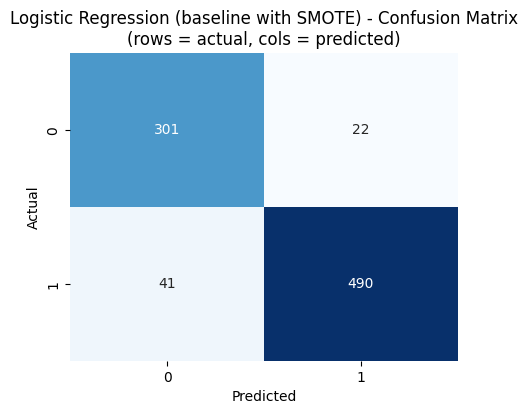


=== Decision Tree (baseline with SMOTE) ===
Accuracy: 0.9754  Precision: 0.9793  Recall: 0.9812  F1: 0.9802

Classification report:
              precision    recall  f1-score   support

           0     0.9689    0.9659    0.9674       323
           1     0.9793    0.9812    0.9802       531

    accuracy                         0.9754       854
   macro avg     0.9741    0.9736    0.9738       854
weighted avg     0.9754    0.9754    0.9754       854



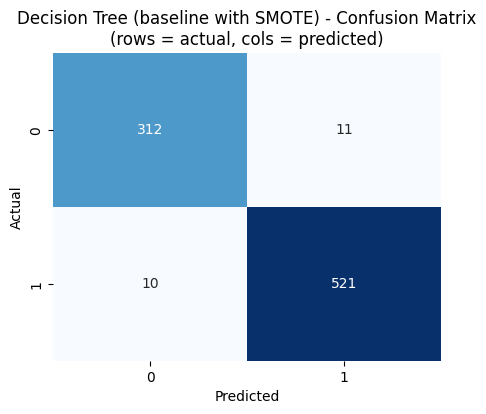

In [38]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{model_name} - Confusion Matrix\n(rows = actual, cols = predicted)")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "cm": cm}

res_lr = evaluate_model(y_test, y_pred_lr, "Logistic Regression (baseline with SMOTE)")
res_dt = evaluate_model(y_test, y_pred_dt, "Decision Tree (baseline with SMOTE)")


In [40]:
RANDOM_STATE = 42
DO_HYPERPARAM_TUNING = True  # set False to skip tuning (faster)
N_ITER_TUNING = 20            # reduce if machine is slow
CV_FOLDS = 3


Starting hyperparameter tuning (RandomizedSearchCV). This may take time...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best DT params: {'clf__criterion': 'entropy', 'clf__max_depth': 18, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 41}

=== Decision Tree (tuned) ===
Accuracy: 0.9859  Precision: 0.9797  Recall: 0.9981  F1: 0.9888

Classification report:
              precision    recall  f1-score   support

           0     0.9968    0.9659    0.9811       323
           1     0.9797    0.9981    0.9888       531

    accuracy                         0.9859       854
   macro avg     0.9882    0.9820    0.9850       854
weighted avg     0.9861    0.9859    0.9859       854



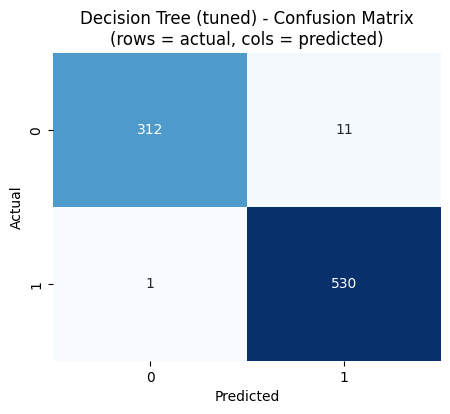

In [41]:
best_lr = lr_pipeline
best_dt = dt_pipeline
res_lr_tuned = res_lr
res_dt_tuned = res_dt

if DO_HYPERPARAM_TUNING:
    print("\nStarting hyperparameter tuning (RandomizedSearchCV). This may take time...")
    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    # Decision Tree tuning space
    dt_param_dist = {
        "clf__max_depth": randint(2, 30),
        "clf__min_samples_split": randint(2, 50),
        "clf__min_samples_leaf": randint(1, 20),
        "clf__criterion": ["gini", "entropy"]
    }
    rand_dt = RandomizedSearchCV(dt_pipeline, dt_param_dist, n_iter=min(N_ITER_TUNING, 40),
                                 scoring="f1", n_jobs=-1, cv=cv, verbose=1, random_state=RANDOM_STATE)
    rand_dt.fit(X_train, y_train)
    best_dt = rand_dt.best_estimator_
    print("Best DT params:", rand_dt.best_params_)
    y_pred_dt_tuned = best_dt.predict(X_test)
    res_dt_tuned = evaluate_model(y_test, y_pred_dt_tuned, "Decision Tree (tuned)")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best LR params: {'clf__C': np.float64(0.5741157902710026), 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}

=== Logistic Regression (tuned) ===
Accuracy: 0.9262  Precision: 0.9570  Recall: 0.9228  F1: 0.9396

Classification report:
              precision    recall  f1-score   support

           0     0.8801    0.9319    0.9053       323
           1     0.9570    0.9228    0.9396       531

    accuracy                         0.9262       854
   macro avg     0.9186    0.9273    0.9224       854
weighted avg     0.9279    0.9262    0.9266       854



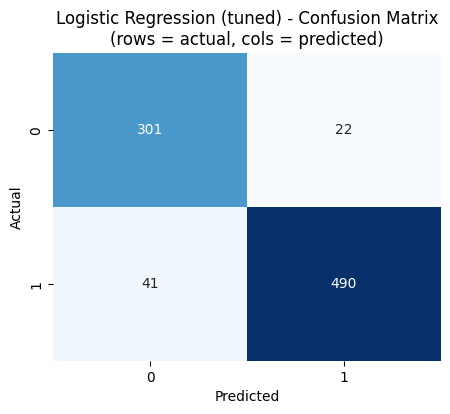

In [42]:
    lr_param_dist = {
        "clf__C": uniform(0.01, 10),
        "clf__penalty": ["l1", "l2"],
        "clf__solver": ["liblinear"]  # support l1
    }
    rand_lr = RandomizedSearchCV(lr_pipeline, lr_param_dist, n_iter=min(N_ITER_TUNING, 40),
                                 scoring="f1", n_jobs=-1, cv=cv, verbose=1, random_state=RANDOM_STATE)
    rand_lr.fit(X_train, y_train)
    best_lr = rand_lr.best_estimator_
    print("Best LR params:", rand_lr.best_params_)
    y_pred_lr_tuned = best_lr.predict(X_test)
    res_lr_tuned = evaluate_model(y_test, y_pred_lr_tuned, "Logistic Regression (tuned)")



=== Summary Comparison ===


,accuracy,precision,recall,f1
model,,,,
LR_baseline,0.926230,0.957031,0.922787,0.939597
DT_baseline,0.975410,0.979323,0.981168,0.980245
LR_tuned,0.926230,0.957031,0.922787,0.939597
DT_tuned,0.985948,0.979667,0.998117,0.988806


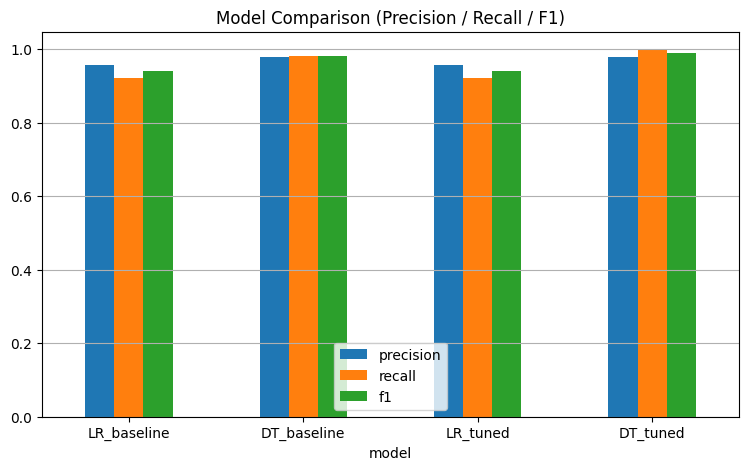

In [43]:
compare_rows = []
compare_rows.append({"model":"LR_baseline","accuracy":res_lr["accuracy"],"precision":res_lr["precision"],"recall":res_lr["recall"],"f1":res_lr["f1"]})
compare_rows.append({"model":"DT_baseline","accuracy":res_dt["accuracy"],"precision":res_dt["precision"],"recall":res_dt["recall"],"f1":res_dt["f1"]})
compare_rows.append({"model":"LR_tuned","accuracy":res_lr_tuned["accuracy"],"precision":res_lr_tuned["precision"],"recall":res_lr_tuned["recall"],"f1":res_lr_tuned["f1"]})
compare_rows.append({"model":"DT_tuned","accuracy":res_dt_tuned["accuracy"],"precision":res_dt_tuned["precision"],"recall":res_dt_tuned["recall"],"f1":res_dt_tuned["f1"]})

compare_df = pd.DataFrame(compare_rows).set_index("model")
print("\n=== Summary Comparison ===")
display(compare_df)

compare_df[["precision","recall","f1"]].plot.bar(rot=0, figsize=(9,5))
plt.title("Model Comparison (Precision / Recall / F1)")
plt.grid(axis="y")
plt.show()

In [44]:
candidates = {
    "lr": (best_lr, res_lr_tuned["f1"]),
    "dt": (best_dt, res_dt_tuned["f1"])
}
best_name = max(candidates.items(), key=lambda x: x[1][1])[0]
best_pipeline = candidates[best_name][0]
joblib.dump(best_pipeline, f"best_loan_pipeline_{best_name}.joblib")
print(f"\nSaved best pipeline: best_loan_pipeline_{best_name}.joblib (best by F1 = {candidates[best_name][1]:.4f})")



Saved best pipeline: best_loan_pipeline_dt.joblib (best by F1 = 0.9888)


In [45]:
print("\nNotes & next steps:")
print("- If memory/time is limited: set DO_HYPERPARAM_TUNING=False and reduce N_ITER_TUNING.")
print("- Try tree ensembles (RandomForest / XGBoost) for potentially better performance.")
print("- Consider calibration of probabilities if you use decision thresholds.")
print("- Use explainability (SHAP / permutation importance) to interpret features.")



Notes & next steps:
- If memory/time is limited: set DO_HYPERPARAM_TUNING=False and reduce N_ITER_TUNING.
- Try tree ensembles (RandomForest / XGBoost) for potentially better performance.
- Consider calibration of probabilities if you use decision thresholds.
- Use explainability (SHAP / permutation importance) to interpret features.
